<img src="http://developer.download.nvidia.com/notebooks/dlsw-notebooks/tensorrt_torchtrt_efficientnet/nvidia_logo.png" width="90px">

# Pyspark TensorFlow Inference

## Image classification
This notebook demonstrates training and distributed inference for image classification on MNIST.  
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

Note that cuFFT/cuDNN/cuBLAS registration errors are expected (as of `tf=2.17.0`) and will not affect behavior, as noted in [this issue.](https://github.com/tensorflow/tensorflow/issues/62075)  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import shutil
import os

import tensorflow as tf
from tensorflow import keras

2025-01-27 12:09:45.634884: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 12:09:45.641535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 12:09:45.649019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 12:09:45.651240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 12:09:45.657098: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.version.VERSION)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2.17.0


I0000 00:00:1738008586.411773 3021472 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738008586.433071 3021472 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738008586.435784 3021472 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


### Load and preprocess dataset

Load MNIST and create a train/test split.

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

train_images.shape, test_images.shape

((1000, 784), (1000, 784))

### Define a model

In [5]:
# Define a simple sequential model
def create_model():
    model = tf.keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

/home/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738008586.592974 3021472 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738008586.595670 3021472 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738008586.598309 3021472 cu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### Save checkpoints during training

In [6]:
os.mkdir("models") if not os.path.exists("models") else None

In [7]:
checkpoint_path = "models/training_1/checkpoint.model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_sparse_categorical_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10


I0000 00:00:1738008587.286019 3021614 service.cc:146] XLA service 0x7e8e7c005520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738008587.286032 3021614 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-01-27 12:09:47.295640: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-27 12:09:47.333525: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/32 ━━━━━━━━━━━━━━━━━━━━ 25s 821ms/step - loss: 2.3309 - sparse_categorical_accuracy: 0.1562

I0000 00:00:1738008587.874862 3021614 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5918 - sparse_categorical_accuracy: 0.5187  

2025-01-27 12:09:49.034107: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.79300, saving model to models/training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.5776 - sparse_categorical_accuracy: 0.5239 - val_loss: 0.6896 - val_sparse_categorical_accuracy: 0.7930
Epoch 2/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5264 - sparse_categorical_accuracy: 0.9062
Epoch 2: val_sparse_categorical_accuracy improved from 0.79300 to 0.82800, saving model to models/training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4540 - sparse_categorical_accuracy: 0.8786 - val_loss: 0.5568 - val_sparse_categorical_accuracy: 0.8280
Epoch 3/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2200 - sparse_categorical_accuracy: 0.9375
Epoch 3: val_sparse_categorical_accuracy improved from 0.82800 to 0.84000, saving model to models/training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2886 - sparse_categorical_accuracy: 0.9285

In [8]:
os.listdir(checkpoint_dir)

['checkpoint.model.keras']

In [9]:
# Export model in saved_model format
model.export("models/mnist_model")

INFO:tensorflow:Assets written to: models/mnist_model/assets


INFO:tensorflow:Assets written to: models/mnist_model/assets


Saved artifact at 'models/mnist_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139159539831760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139159206493264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139163873256720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139159206493456: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [10]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

/home/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 - 0s - 12ms/step - loss: 2.3042 - sparse_categorical_accuracy: 0.1720
Untrained model, accuracy: 17.20%


In [11]:
# Load the weights from the checkpoint
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - 776us/step - loss: 0.4069 - sparse_categorical_accuracy: 0.8730
Restored model, accuracy: 87.30%


/home/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Checkpoint callback options

In [12]:
os.mkdir("models/training_2") if not os.path.exists("models/training_2") else None

In [13]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "models/training_2/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Calculate the number of batches per epoch
import math
n_batches = len(train_images) / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*n_batches)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_images, 
          train_labels,
          epochs=50, 
          batch_size=batch_size, 
          callbacks=[cp_callback],
          validation_data=(test_images, test_labels),
          verbose=0)


Epoch 5: saving model to models/training_2/cp-0005.weights.h5

Epoch 10: saving model to models/training_2/cp-0010.weights.h5

Epoch 15: saving model to models/training_2/cp-0015.weights.h5

Epoch 20: saving model to models/training_2/cp-0020.weights.h5

Epoch 25: saving model to models/training_2/cp-0025.weights.h5

Epoch 30: saving model to models/training_2/cp-0030.weights.h5

Epoch 35: saving model to models/training_2/cp-0035.weights.h5

Epoch 40: saving model to models/training_2/cp-0040.weights.h5

Epoch 45: saving model to models/training_2/cp-0045.weights.h5

Epoch 50: saving model to models/training_2/cp-0050.weights.h5


In [14]:
os.listdir(checkpoint_dir)

['cp-0000.weights.h5',
 'cp-0015.weights.h5',
 'cp-0010.weights.h5',
 'cp-0035.weights.h5',
 'cp-0020.weights.h5',
 'cp-0040.weights.h5',
 'cp-0050.weights.h5',
 'cp-0005.weights.h5',
 'cp-0045.weights.h5',
 'cp-0025.weights.h5',
 'cp-0030.weights.h5']

In [15]:
latest = "models/training_2/cp-0030.weights.h5"

In [16]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model from the latest checkpoint
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - 8ms/step - loss: 0.4725 - sparse_categorical_accuracy: 0.8700
Restored model, accuracy: 87.00%


## PySpark

In [17]:
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array, pandas_udf
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkConf
import pandas as pd
import json

Check the cluster environment to handle any platform-specific Spark configurations.

In [18]:
on_databricks = os.environ.get("DATABRICKS_RUNTIME_VERSION", False)
on_dataproc = os.environ.get("DATAPROC_IMAGE_VERSION", False)
on_standalone = not (on_databricks or on_dataproc)

#### Create Spark Session

For local standalone clusters, we'll connect to the cluster and create the Spark Session.  
For CSP environments, Spark will either be preconfigured (Databricks) or we'll need to create the Spark Session (Dataproc).

In [19]:
conf = SparkConf()

if 'spark' not in globals():
    if on_standalone:
        import socket
        
        conda_env = os.environ.get("CONDA_PREFIX")
        hostname = socket.gethostname()
        conf.setMaster(f"spark://{hostname}:7077")
        conf.set("spark.pyspark.python", f"{conda_env}/bin/python")
        conf.set("spark.pyspark.driver.python", f"{conda_env}/bin/python")
        # Point PyTriton to correct libpython3.11.so:
        conf.set("spark.executorEnv.LD_LIBRARY_PATH", f"{conda_env}/lib:{conda_env}/lib/python3.11/site-packages/nvidia_pytriton.libs:$LD_LIBRARY_PATH")
        source = "/usr/lib/x86_64-linux-gnu/libstdc++.so.6"
        target = f"{conda_env}/lib/libstdc++.so.6"
        try:
            if os.path.islink(target) or os.path.exists(target):
                os.remove(target)
            os.symlink(source, target)
        except OSError as e:
            print(f"Error creating symlink: {e}")
    elif on_dataproc:
        # Point PyTriton to correct libpython3.11.so:
        conda_lib_path="/opt/conda/miniconda3/lib"
        conf.set("spark.executorEnv.LD_LIBRARY_PATH", f"{conda_lib_path}:$LD_LIBRARY_PATH")
        conf.set("spark.executorEnv.TF_GPU_ALLOCATOR", "cuda_malloc_async")
        conf.set("spark.executor.instances", "4") # dataproc defaults to 2

    conf.set("spark.executor.cores", "8")
    conf.set("spark.task.resource.gpu.amount", "0.125")
    conf.set("spark.executor.resource.gpu.amount", "1")
    conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
    conf.set("spark.python.worker.reuse", "true")

conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1000")
spark = SparkSession.builder.appName("spark-dl-examples").config(conf=conf).getOrCreate()
sc = spark.sparkContext

25/01/27 20:09:55 WARN Utils: Your hostname, cb4ae00-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.47.100 instead (on interface eno1)
25/01/27 20:09:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/27 20:09:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/27 20:09:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Create Spark Dataframe

In [20]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images)
test_pdf.shape

(1000, 784)

In [21]:
df = spark.createDataFrame(test_pdf).repartition(8)

### Save as Parquet (784 columns of float)

In [22]:
%%time
data_path_784 = "spark-dl-datasets/mnist_784"
if on_databricks:
    dbutils.fs.mkdirs("/FileStore/spark-dl-datasets")
    data_path_784 = "dbfs:/FileStore/" + data_path_784

df.write.mode("overwrite").parquet(data_path_784)

25/01/27 20:09:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 3.02 ms, sys: 1.31 ms, total: 4.33 ms
Wall time: 1.92 s


### Save as Parquet (1 column of 784 float)

In [23]:
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

(1000, 1)

In [24]:
df = spark.createDataFrame(pdf)

In [25]:
%%time
data_path_1 = "spark-dl-datasets/mnist_1"
if on_databricks:
    dbutils.fs.mkdirs("/FileStore/spark-dl-datasets")
    data_path_1 = "dbfs:/FileStore/" + data_path_1

df.write.mode("overwrite").parquet(data_path_1)

CPU times: user 16 μs, sys: 1.01 ms, total: 1.02 ms
Wall time: 218 ms


## Inference using Spark DL API

Distributed inference using the PySpark [predict_batch_udf](https://spark.apache.org/docs/3.4.0/api/python/reference/api/pyspark.ml.functions.predict_batch_udf.html#pyspark.ml.functions.predict_batch_udf):

- predict_batch_fn uses Tensorflow APIs to load the model and return a predict function which operates on numpy arrays 
- predict_batch_udf will convert the Spark DataFrame columns into numpy input batches for the predict function

### 1 column of 784 float

In [26]:
model_path = "{}/models/training_1/checkpoint.model.keras".format(os.getcwd())

# For cloud environments, copy the model to the distributed file system.
if on_databricks:
    dbutils.fs.mkdirs("/FileStore/spark-dl-models")
    dbfs_model_path = "/dbfs/FileStore/spark-dl-models/checkpoint.model.keras"
    shutil.copy(model_path, dbfs_model_path)
    model_path = dbfs_model_path
elif on_dataproc:
    # GCS is mounted at /mnt/gcs by the init script
    models_dir = "/mnt/gcs/spark-dl/models"
    os.mkdir(models_dir) if not os.path.exists(models_dir) else None
    gcs_model_path = models_dir + "/checkpoint.model.keras"
    shutil.copy(model_path, gcs_model_path)
    model_path = gcs_model_path

In [27]:
def predict_batch_fn():
    import tensorflow as tf

    # Enable GPU memory growth to avoid CUDA OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    model = tf.keras.models.load_model(model_path)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [28]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=128,
                          input_tensor_shapes=[[784]])

In [29]:
df = spark.read.parquet(data_path_1)
len(df.columns)

1

In [30]:
df.show(5)

+--------------------+
|                data|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



In [31]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 22.4 ms, sys: 14.1 ms, total: 36.5 ms
Wall time: 5.89 s


In [32]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 27.2 ms, sys: 12.8 ms, total: 40 ms
Wall time: 259 ms


In [33]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 40.1 ms, sys: 8.81 ms, total: 48.9 ms
Wall time: 231 ms


#### Check predictions

In [34]:
preds = df.withColumn("preds", mnist(*df.columns)).limit(10).toPandas()
preds

,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.982547, -2.495611, 1.2573445, 12.891551, -..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.95476156, -5.622215, 2.241567, -2.0017645,..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.9178914, 0.43411195, 1.9357576, 1.7975042,..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.21153986, -5.5822043, 11.524151, 2.8064005,..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.3954644, 3.7420855, -0.2531985, 0.1679054,..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.1469436, -2.4765797, 3.0782855, 4.3063755,..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.9109762, 4.0204973, 1.3597142, -0.00311854..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.3474851, -0.7892854, -4.275904, 0.51054317..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0500484, -2.2071126, -0.07787762, -3.207581..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0029632095, -1.7498987, -2.1225448, 2.1881..."


In [35]:
sample = preds.iloc[0]
sample.preds

array([-2.982547  , -2.495611  ,  1.2573445 , 12.891551  , -5.40115   ,
        2.7227228 , -6.900943  , -1.4402989 ,  0.59647846, -3.8927622 ],
      dtype=float32)

In [36]:
import matplotlib.pyplot as plt
import numpy as np

In [37]:
prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

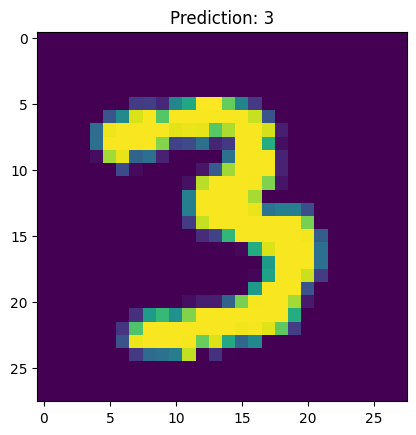

In [38]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

### 784 columns of float

In [39]:
def predict_batch_fn():
    import tensorflow as tf
    # Enable GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
            
    model = tf.keras.models.load_model(model_path)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [40]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=128,
                          input_tensor_shapes=[[784]])

In [41]:
df = spark.read.parquet(data_path_784)
len(df.columns)

784

In [42]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

CPU times: user 53.2 ms, sys: 31.2 ms, total: 84.4 ms
Wall time: 6.21 s


In [43]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 54.5 ms, sys: 20.1 ms, total: 74.6 ms
Wall time: 1.95 s


In [44]:
# should raise ValueError
# preds = df.withColumn("preds", mnist(*df.columns)).collect()

### Check prediction

In [45]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,preds
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-6.554102, 2.085586, 1.3187729, 0.7378275, -4..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.8565233, 4.518864, -1.2931982, -0.78954405..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.7759259, -2.682865, -1.2959752, -5.4488983..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.15489274, -1.4305159, -1.5703316, 1.2637339..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.9276226, 4.4247217, 1.0965542, 0.3403727, ..."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[8.987603, -3.3934922, 2.4643059, -0.84833026,..."
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[7.024207, -3.5837536, 1.645798, 0.86984664, -..."
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[3.0095522, -4.574903, 0.7152054, -5.211629, 4..."
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-1.548282, -3.065774, 10.493741, -1.5243877, ..."
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-1.5818219, -3.821816, -3.4366767, 7.7891817,..."


In [46]:
import matplotlib.pyplot as plt
import numpy as np

In [47]:
sample = preds.iloc[0]
sample.preds

array([-6.554102 ,  2.085586 ,  1.3187729,  0.7378275, -4.1074104,
       -3.352563 , -4.2061253,  4.6558733,  1.0386009,  0.9432423],
      dtype=float32)

In [48]:
prediction = np.argmax(sample.preds)
img = sample.drop('preds').to_numpy(dtype=float)
img = np.array(img).reshape(28,28)

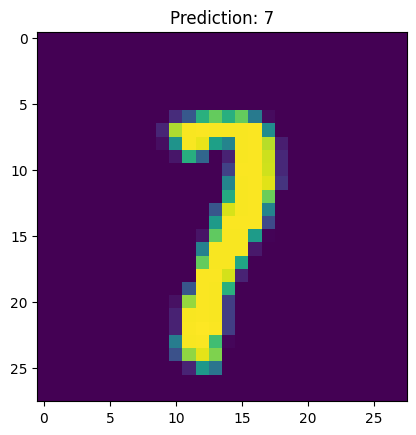

In [49]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

## Using Triton Inference Server
In this section, we demonstrate integration with the [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server), an open-source, GPU-accelerated serving solution for DL.  
We use [PyTriton](https://github.com/triton-inference-server/pytriton), a Flask-like framework that handles client/server communication with the Triton server.  

The process looks like this:
- Distribute a PyTriton task across the Spark cluster, instructing each node to launch a Triton server process.
- Define a Triton inference function, which contains a client that binds to the local server on a given node and sends inference requests.
- Wrap the Triton inference function in a predict_batch_udf to launch parallel inference requests using Spark.
- Finally, distribute a shutdown signal to terminate the Triton server processes on each node.

<img src="../images/spark-pytriton.png" alt="drawing" width="700"/>

In [50]:
from functools import partial

Import the utility functions from pytriton_utils.py:

In [51]:
if on_standalone:
    import sys
    # import from parent dir dl_inference/
    notebooks_dir = os.path.dirname(os.path.abspath("__file__"))
    examples_dir = os.path.abspath(os.path.join(notebooks_dir, ".."))
    sys.path.insert(0, examples_dir)

from pytriton_utils import (
    use_stage_level_scheduling,
    find_ports,
    start_triton,
    stop_triton
)

Define the Triton Server function:

In [52]:
def triton_server(ports, model_path):
    import time
    import signal
    import numpy as np
    from pytriton.decorators import batch
    from pytriton.model_config import DynamicBatcher, ModelConfig, Tensor
    from pytriton.triton import Triton, TritonConfig
    from pyspark import TaskContext
    import tensorflow as tf
    from tensorflow import keras

    print(f"SERVER: Initializing model on worker {TaskContext.get().partitionId()}.")

    # Enable GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    model = keras.models.load_model(model_path)

    @batch
    def _infer_fn(**inputs):
        images = np.squeeze(inputs["images"])
        print(f"SERVER: Received batch of size {len(images)}.")
        return {
            "labels": model.predict(images)
        }

    workspace_path = f"/tmp/triton_{time.strftime('%m_%d_%M_%S')}"
    triton_conf = TritonConfig(http_port=ports[0], grpc_port=ports[1], metrics_port=ports[2])
    with Triton(config=triton_conf, workspace=workspace_path) as triton:
        triton.bind(
            model_name="ImageClassifier",
            infer_func=_infer_fn,
            inputs=[
                Tensor(name="images", dtype=np.float64, shape=(-1,)),
            ],
            outputs=[
                Tensor(name="labels", dtype=np.float32, shape=(-1,)),
            ],
            config=ModelConfig(
                max_batch_size=128,
                batcher=DynamicBatcher(max_queue_delay_microseconds=5000),  # 5ms
            ),
            strict=True,
        )

        def _stop_triton(signum, frame):
            print("SERVER: Received SIGTERM. Stopping Triton server.")
            triton.stop()

        signal.signal(signal.SIGTERM, _stop_triton)

        print("SERVER: Serving inference")
        triton.serve()

#### Start Triton servers

**Specify the number of nodes in the cluster.**  
Following the README, the example standalone cluster uses 1 node. The example Databricks/Dataproc cluster scripts use 4 nodes by default. 

In [53]:
# Change based on cluster setup
num_nodes = 1 if on_standalone else 4

To ensure that only one Triton inference server is started per node, we use stage-level scheduling to delegate each task to a separate GPU.  

In [54]:
sc = spark.sparkContext
nodeRDD = sc.parallelize(list(range(num_nodes)), num_nodes)
nodeRDD = use_stage_level_scheduling(spark, nodeRDD)

Reqesting stage-level resources: (cores=5, gpu=1.0)


Triton occupies ports for HTTP requests, GRPC requests, and the metrics service.

In [55]:
model_name = "ImageClassifier"
ports = find_ports()
assert len(ports) == 3
print(f"Using ports {ports}")

Using ports [7000, 7001, 7002]


In [56]:
pids = nodeRDD.barrier().mapPartitions(lambda _: start_triton(triton_server_fn=triton_server,
                                                              ports=ports,
                                                              model_name=model_name,
                                                              model_path=model_path)).collectAsMap()
print("Triton Server PIDs:\n", json.dumps(pids, indent=4))

Triton Server PIDs:
 {
    "cb4ae00-lcedt": 3034797
}


#### Define client function

In [57]:
url = f"http://localhost:{ports[0]}"

In [58]:
def triton_fn(url, model_name):
    from pytriton.client import ModelClient

    print(f"Connecting to Triton model {model_name} at {url}.")

    def infer_batch(inputs):
        with ModelClient(url, model_name, inference_timeout_s=240) as client:
            result_data = client.infer_batch(inputs)
            return result_data["labels"]
        
    return infer_batch

#### Run inference

In [59]:
df = spark.read.parquet(data_path_1)
df.schema

StructType([StructField('data', ArrayType(DoubleType(), True), True)])

In [60]:
predict = predict_batch_udf(partial(triton_fn, url=url, model_name=model_name),
                            input_tensor_shapes=[[784]],
                            return_type=ArrayType(FloatType()),
                            batch_size=128)

In [61]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 21.3 ms, sys: 5.16 ms, total: 26.5 ms
Wall time: 1.7 s


In [62]:
%%time
preds = df.withColumn("preds", predict("data")).collect()

CPU times: user 17.4 ms, sys: 7.83 ms, total: 25.3 ms
Wall time: 445 ms


In [63]:
%%time
preds = df.withColumn("preds", predict(col("data"))).limit(10).toPandas()
preds

CPU times: user 8.15 ms, sys: 2.67 ms, total: 10.8 ms
Wall time: 892 ms


,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.9825501, -2.4956138, 1.2573452, 12.891572,..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.9547625, -5.622221, 2.2415693, -2.0017662,..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.9178927, 0.4341122, 1.9357599, 1.7975069, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2115398, -5.582211, 11.52417, 2.8064039, -3..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.395469, 3.7420897, -0.25319868, 0.16790543..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.1469467, -2.4765825, 3.0782876, 4.3063807,..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.9109812, 4.020501, 1.359716, -0.003118489,..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.3475021, -0.7891858, -4.275926, 0.51047605..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0500505, -2.2071157, -0.07787818, -3.207583..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0029557291, -1.7499021, -2.1225464, 2.1881..."


In [64]:
import matplotlib.pyplot as plt
import numpy as np

In [65]:
sample = preds.iloc[0]
sample.preds

prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

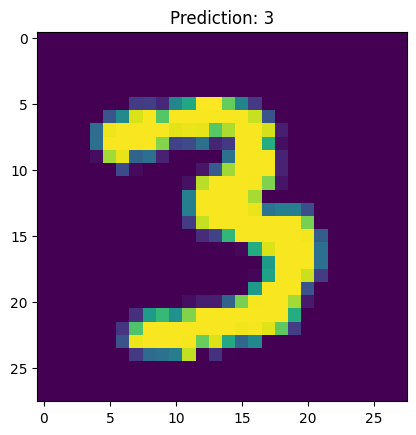

In [66]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

#### Stop Triton Server on each executor

In [67]:
shutdownRDD = sc.parallelize(list(range(num_nodes)), num_nodes)
shutdownRDD = use_stage_level_scheduling(spark, shutdownRDD)
shutdownRDD.barrier().mapPartitions(lambda _: stop_triton(pids)).collect()

Reqesting stage-level resources: (cores=5, gpu=1.0)


[True]

In [68]:
if not on_databricks: # on databricks, spark.stop() puts the cluster in a bad state
    spark.stop()